# Fixes to Precision-Recall curve

The pixel classification metrics were originally tested with smoothly distributed values.
For example values output by a softmax would range from 0 to 1 and given a usual U-Net we would observe smoothly changing logit levels.

The implementation however creates wrong results in some cases - for instance if we the prediction is binary, score = 0 or 1.


- In dynamic binning mode, set bin edges to surround the whole range of values by adding extra bin edges at `minval - eps` and `maxval + eps`.
	This allows us to correctly treat groups of sharp 0s and 1s scores.
	
- When calculating PR curve, ensure the curve starts at precision=1,recall=0 and ends at recall=1

- Area under PR curve is calculated according to sklearn and ignores the areas where the curve rises, instead taking a flat section of the graph.
	(see images)

- Curve segments for repeated thresholds are collapsed.

In [36]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import numpy as np
from easydict import EasyDict
from tqdm import tqdm

from road_anomaly_benchmark.evaluation import Evaluation
from road_anomaly_benchmark.datasets import DatasetRegistry
from road_anomaly_benchmark.metrics import MetricRegistry

In [38]:
from matplotlib import pyplot
%matplotlib inline

## Before fix

In [39]:
def binary_confusion_matrix_orig(
		prob : np.ndarray, gt_label_bool : np.ndarray, 
		num_bins : int = 1024, bin_strategy = 'uniform', # : Literal['uniform', 'percentiles'] = 'uniform',
		normalize : bool = False, dtype = np.float64):
	
	area = gt_label_bool.__len__()

	gt_area_true = np.count_nonzero(gt_label_bool)
	gt_area_false = area - gt_area_true

	prob_at_true = prob[gt_label_bool]
	prob_at_false = prob[~gt_label_bool]

	if bin_strategy == 'uniform':
		# bins spread uniforms in 0 .. 1
		bins = num_bins
		histogram_range = [0, 1]

	elif bin_strategy == 'percentiles':
		# dynamic bins representing the range of occurring values
		# bin edges are following the distribution of positive and negative pixels

		bins = [
			[0, 1], # make sure 0 and 1 are included
		]

		if prob_at_true.size:
			bins += [
				np.quantile(prob_at_true, np.linspace(0, 1, min(num_bins//2, prob_at_true.size))),
			]
		if prob_at_false.size:
			bins += [
				np.quantile(prob_at_false, np.linspace(0, 1, min(num_bins//2, prob_at_false.size))),
			]

			
		bins = np.concatenate(bins)
		
		# sort and remove duplicates, duplicated cause an exception in np.histogram
		bins = np.unique(bins)
		

		histogram_range = None

	# the area of positive pixels is divided into
	#	- true positives - above threshold
	#	- false negatives - below threshold
	tp_rel, _ = np.histogram(prob_at_true, bins=bins, range=histogram_range)
	# the curve goes from higher thresholds to lower thresholds
	tp_rel = tp_rel[::-1]
	# cumsum to get number of tp at given threshold
	tp = np.cumsum(tp_rel)
	# GT-positives which are not TP are instead FN
	fn = gt_area_true - tp

	# the area of negative pixels is divided into
	#	- false positives - above threshold
	#	- true negatives - below threshold
	fp_rel, bin_edges = np.histogram(prob_at_false, bins=bins, range=histogram_range)
	# the curve goes from higher thresholds to lower thresholds
	bin_edges = bin_edges[::-1]
	fp_rel = fp_rel[::-1]
	# cumsum to get number of fp at given threshold
	fp = np.cumsum(fp_rel)
	# GT-negatives which are not FP are instead TN
	tn = gt_area_false - fp

	cmat_sum = np.array([
		[tp, fp],
		[fn, tn],
	]).transpose(2, 0, 1).astype(dtype)

	# cmat_rel = np.array([
	# 	[tp_rel, fp_rel],
	# 	[-tp_rel, -fp_rel],
	# ]).transpose(2, 0, 1).astype(dtype)
	
	if normalize:
		cmat_sum *= (1./area)
		# cmat_rel *= (1./area)

	return EasyDict(
		bin_edges = bin_edges,
		cmat_sum = cmat_sum,
		# cmat_rel = cmat_rel,
		tp_rel = tp_rel,
		fp_rel = fp_rel,
		num_pos = gt_area_true,
		num_neg = gt_area_false,
	)


def get_no_prediction_prefix(cmats):
	"""
	The threshold goes from high to low
	At the beginning, we have 0 predictions and there is no valid precision
	Remove the prefix with 0 predictions

	This function returns the number of elements to remove from the beginning.
	"""

	for i in range(cmats.__len__()):
		if cmats[i, 0, 0] + cmats[i, 0, 1] > 0.01:
			return i

	raise ValueError('No predictions made at all')


def curves_from_cmats_orig(cmats, thresholds):
	
	# The threshold goes from high to low
	# At the beginning, we have 0 predictions and there is no valid precision
	# Remove the prefix with 0 predictions

	num_remove = get_no_prediction_prefix(cmats)

	if num_remove > 0:
		print(f'Skip {num_remove}')
		cmats = cmats[num_remove:]
		thresholds = thresholds[num_remove:]

	tp = cmats[:, 0, 0]
	fp = cmats[:, 0, 1]
	fn = cmats[:, 1, 0]
	tn = cmats[:, 1, 1]

	tp_rates = tp / (tp+fn)
	fp_rates = fp / (fp+tn)

	precisions = tp / (tp+fp)
	recalls = tp / (tp+fn)
	f1_scores = (2 * tp) / (2 * tp + fp + fn)

	tpr95_index = np.searchsorted(tp_rates, 0.95)
	if tpr95_index < tp_rates.shape[0]:
		fpr_tpr95 = fp_rates[tpr95_index]
		tpr95_threshold = float(thresholds[tpr95_index])
	else:
		# tpr95 was not reached
		fpr_tpr95 = 1.0
		tpr95_threshold = 0.0

	recall50_index = np.searchsorted(recalls, 0.50)
	recall50_threshold = float(thresholds[recall50_index])

	ix = np.nanargmax(f1_scores)
	best_f1_threshold = float(thresholds[ix])
	best_f1 = f1_scores[ix]

	print(
		'ap-sum', np.sum(np.diff(recalls) * precisions[:-1]),
		'ap-trapz', np.trapz(precisions, recalls),
	)

	return EasyDict(
		# curves
		curve_tpr = tp_rates,
		curve_fpr = fp_rates,
		curve_precision = precisions,
		curve_recall = recalls,
		
		thresholds = thresholds,

		# areas
		area_ROC = np.trapz(tp_rates, fp_rates),
		area_PRC = np.trapz(precisions, recalls),

		tpr95_fpr = fpr_tpr95,
		tpr95_threshold = tpr95_threshold,

		recall50_threshold = recall50_threshold,
		best_f1_threshold = best_f1_threshold,
		best_f1 = best_f1

	)

def aggregate_dynamic_bins_orig(frame_results):

	thresholds = np.concatenate([r.bin_edges[1:] for r in frame_results])

	tp_relative = np.concatenate([r.tp_rel for r in frame_results], axis=0)
	fp_relative = np.concatenate([r.fp_rel for r in frame_results], axis=0)

	num_positives = sum(r.num_pos for r in frame_results)
	num_negatives = sum(r.num_neg for r in frame_results)


	threshold_order = np.argsort(thresholds)[::-1]

	# We start at threshold = 1, and lower it
	# Initially, prediction=0, all GT=1 pixels are false-negatives, and all GT=0 pixels are true-negatives.

	tp_cumu = np.cumsum(tp_relative[threshold_order].astype(np.float64))
	fp_cumu = np.cumsum(fp_relative[threshold_order].astype(np.float64))

	cmats = np.array([
		# tp, fp
		[tp_cumu, fp_cumu],
		# fn, tn
		[num_positives - tp_cumu, num_negatives - fp_cumu],
	]).transpose([2, 0, 1])

	# cmats = np.concatenate([[
	# 	0, 0,
	# 	num_positives, num_negatives,
	# ]])

	return EasyDict(
		cmat = cmats,
		thresholds = thresholds[threshold_order],
	)



In [40]:
from road_anomaly_benchmark.metrics.pixel_classification_curves import BinaryClassificationCurve, curves_from_cmats
from road_anomaly_benchmark.metrics.pixel_classification import binary_confusion_matrix, MetricPixelClassification

from sklearn.metrics import PrecisionRecallDisplay, average_precision_score


def segme_ap_orig(label_pixel_gt, anomaly_p, reps=1):
	fr_cm = binary_confusion_matrix_orig(
		prob = anomaly_p,
		gt_label_bool = label_pixel_gt,
		num_bins = 768,
		bin_strategy = 'percentiles',
	)
	
	ag = aggregate_dynamic_bins_orig([fr_cm]*reps)	
	curves = curves_from_cmats_orig(ag.cmat, ag.thresholds)

	bc_info = BinaryClassificationCurve(
		method_name = 'gt',
		dataset_name = '?',
		**curves,
	)
	return bc_info

def segme_ap_new(label_pixel_gt, anomaly_p, reps=1):
	fr_cm = binary_confusion_matrix(
		prob = anomaly_p,
		gt_label_bool = label_pixel_gt,
		num_bins = 768,
		bin_strategy = 'percentiles',
	)
	
	ag = MetricPixelClassification.aggregate_dynamic_bins([fr_cm]*reps)	
	curves = curves_from_cmats(ag.cmat, ag.thresholds)

	bc_info = BinaryClassificationCurve(
		method_name = 'gt',
		dataset_name = '?',
		**curves,
	)
	
	return bc_info
	
def plot_curve(plot, bc_info, title):
	plot.plot(  bc_info.curve_recall,  bc_info.curve_precision, label=f'AuPRC = {bc_info.area_PRC}')
	plot.set_xlabel('recall')
	plot.set_ylabel('precision')
	plot.legend()
	plot.set_title(title)
	
	
def auprc_sklearn(label_pixel_gt, anomaly_p, plot=None):
	ap_sklearn = average_precision_score(label_pixel_gt, anomaly_p)

	display = PrecisionRecallDisplay.from_predictions(
		label_pixel_gt, anomaly_p, 
		ax = plot,
	)
	return ap_sklearn


def test_curves(label_pixel_gt, anomaly_p, reps=1, dsname='NONE'):
	label_pixel_gt = np.array(label_pixel_gt, dtype=bool)
	anomaly_p = np.array(anomaly_p, dtype=np.float32)
	
	
	fig, plots = pyplot.subplots(1, 3, figsize = (15, 5))

	c1 = segme_ap_orig(label_pixel_gt, anomaly_p, reps=reps)
	c2 = segme_ap_new(label_pixel_gt, anomaly_p, reps=reps)
	
	for idx, (curve, title) in enumerate([(c1, 'Segme Orig'), (c2, 'Segme Fixed')]):
		plot_curve(plots[idx], curve, title)
	
	auprc_sklearn(
		np.repeat(label_pixel_gt, reps), 
		np.repeat(anomaly_p, reps),
		plot = plots[2],
	)
	plots[2].set_title('sklearn')
	
	

ap-sum 0.3875000000000001 ap-trapz 0.3875000000000001
ap-sum 1.0 ap-trapz 1.0


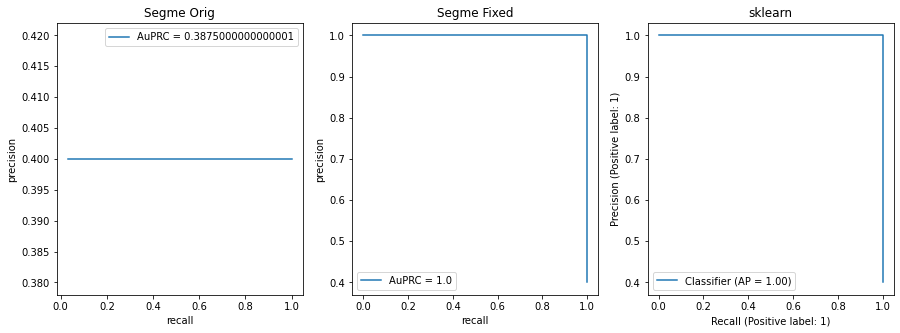

In [41]:
test_curves(
	[False, False, False, True, True],
	[0., 0., 0., 1., 1.],
	reps=32,
)


ap-sum 0.5 ap-trapz 0.5
ap-sum 1.0 ap-trapz 1.0


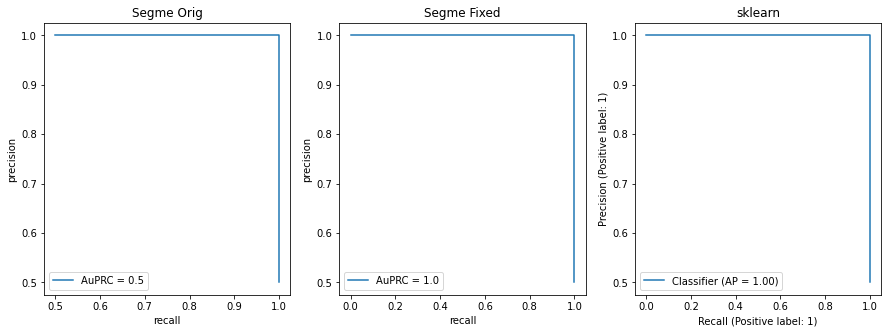

In [42]:
test_curves(
	[False, True, False, True],
	[0.1, 0.4, 0.35, 0.8],
)
	

In [43]:
# np.nonzero([True, False, False])
# np.nonzero?

ap-sum 0.7520883793683228 ap-trapz 0.755560601590545
ap-sum 0.8333333333333333 ap-trapz 0.7916666666666666


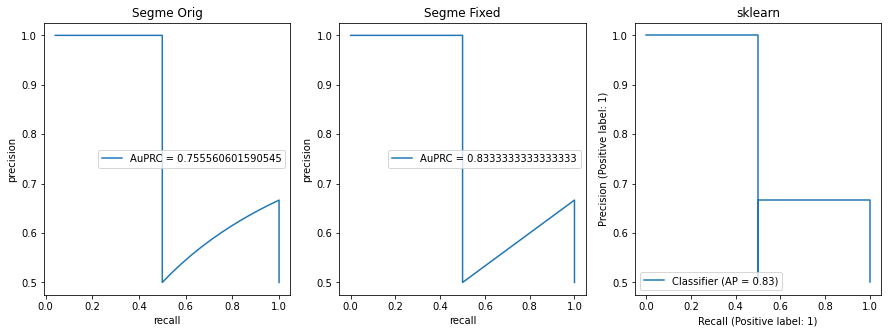

In [44]:
test_curves(
	[False, False, True, True],
	[0.1, 0.4, 0.35, 0.8],
	reps=12,
)
	

ap-sum 0.0 ap-trapz 0.0
ap-sum 0.5 ap-trapz 0.75


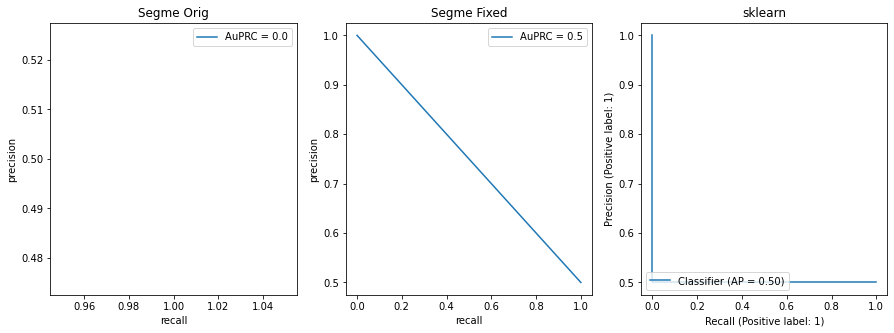

In [45]:
test_curves(
	[False, False, True, True],
	[0.5, 0.5, 0.5, 0.5],
	# reps=16,
)


ap-sum 0.6783029420443059 ap-trapz 0.6784114489887502
ap-sum 0.9166666666666666 ap-trapz 0.9027777777777777


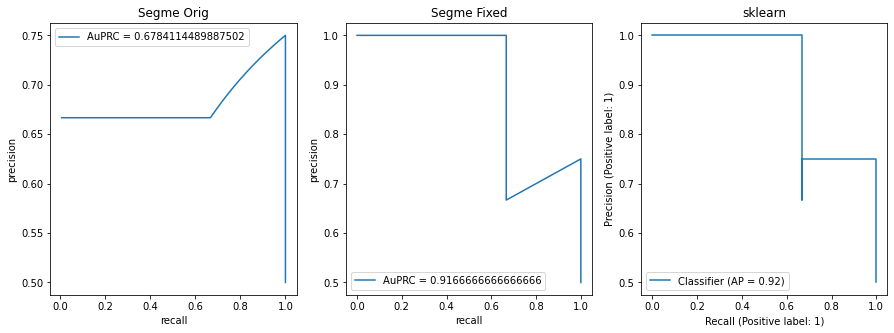

In [46]:
c = test_curves(
	[False, False, False, True, True, True],
	[0., 0., 0.9, 0.1, 1., 1.],
	reps=128,
)
# dir(c)
# c.thresholds


## Test method which returns GT

In [47]:
dsname = 'ObstacleTrack-validation'
dset = DatasetRegistry.get(dsname)

fr = dset[0]
fr.keys()

2023-08-05 18:20:39,082 | road_anomaly_benchmark.datasets.tracks INFO | ObstacleTrack-validation: Exclude 30 -> 30


dict_keys(['fid', 'dset_name', 'image', 'semantic_class_gt', 'label_pixel_gt'])

In [48]:
# show([fr.image, fr.label_pixel_gt == 1, fr.label_pixel_gt.astype(bool).astype(np.float16)])

100%|██████████| 30/30 [00:01<00:00, 28.38it/s]


ap-sum 1.0 ap-trapz 1.0


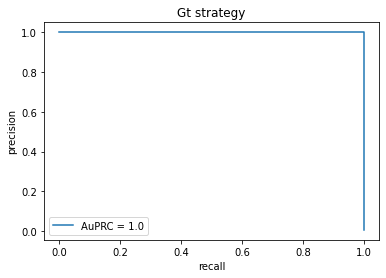

In [49]:

def method_gt(label_pixel_gt, **_):
	anomaly_p = label_pixel_gt.astype(bool).astype(np.float16)
	# anomaly_p = (label_pixel_gt == 1).astype(np.float16)
	return anomaly_p


dsname = 'ObstacleTrack-validation'

def infer():

	ev = Evaluation(
		method_name = 'gt', 
		dataset_name = dsname,
	)
	dset = DatasetRegistry.get(dsname)
	
	# for frame in tqdm(ev.get_frames()):
	for frame in tqdm(dset):
		# run method here
		result = method_gt(**frame)
		# provide the output for saving
		ev.save_output(frame, result)

	# wait for the background threads which are saving
	ev.wait_to_finish_saving()
	
	curve = ev.calculate_metric_from_saved_outputs('PixBinaryClass')

	fig, plot = pyplot.subplots(1, 1)
	plot_curve(plot, curve, 'Gt strategy')
	
infer()
	
